In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import src.bayesian_stats as bst
import xarray as xr
import aesara.tensor as at

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.3.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95

In [3]:
df = pd.read_csv('../kruschke_data/Salary.csv', usecols=[0,3,5], dtype={'Org': 'category', 'Pos': 'category'})
df.head()

Org  Pos  Salary
0    PL  FT2   72395
1  MUTH  FT2   61017
2   ENG  FT2   82370
3  CMLT  FT2   68805
4  LGED  FT3   63796

In [4]:
# Reorder the Pos categories and rename categories
df.Pos.cat.reorder_categories(['FT3', 'FT2', 'FT1', 'NDW', 'DST'], ordered=True, inplace=True)
df.Pos.cat.rename_categories(['Assis', 'Assoc', 'Full', 'Endow', 'Disting'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Org     1080 non-null   category
 1   Pos     1080 non-null   category
 2   Salary  1080 non-null   int64   
dtypes: category(2), int64(1)
memory usage: 13.4 KB


/var/folders/42/fy648srd41l966jbjlswhljc0000gn/T/ipykernel_49458/2492486118.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df.Pos.cat.reorder_categories(['FT3', 'FT2', 'FT1', 'NDW', 'DST'], ordered=True, inplace=True)
/var/folders/42/fy648srd41l966jbjlswhljc0000gn/T/ipykernel_49458/2492486118.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df.Pos.cat.rename_categories(['Assis', 'Assoc', 'Full', 'Endow', 'Disting'], inplace=True)


In [5]:
df.groupby('Pos').apply(lambda x: x.head(2))

Org      Pos  Salary
Pos                               
Assis   4    LGED    Assis   63796
        6    INFO    Assis   98814
Assoc   0      PL    Assoc   72395
        1    MUTH    Assoc   61017
Full    7    CRIN     Full  107745
        9     PSY     Full  173302
Endow   5    MGMT    Endow  219600
        8    CRIN    Endow  114275
Disting 29   SPEA  Disting  285000
        128  MUHI  Disting  114189

In [17]:
y = df.Salary
mu_y = y.mean()
sigma_y = y.std()

x1 = df.Pos
x2 = df.Org

a_shape, a_rate = bst.gamma_shape_rate_from_mode_sd(sigma_y / 2 , 2 * sigma_y)
x1_vals, levels1, n_levels1 = bst.parse_categorical(x1)
x2_vals, levels2, n_levels2 = bst.parse_categorical(x2)

with pm.Model(coords={"rank": levels1, "dept": levels2}) as model:
    
    #a0 = pm.Normal('a0', mu_y, tau=1/(sigma_y*5)**2)
    a0_tilde = pm.Normal('a0_tilde', mu=0, sigma=1)
    a0 = pm.Deterministic('a0', mu_y + sigma_y * 5 * a0_tilde)
        
    sigma_a1 = pm.Gamma('sigma_a1', a_shape, a_rate)
    #a1 = pm.Normal('a1', 0.0, tau=1/sigma_a1**2, shape=n_levels1)
    a1_tilde = pm.Normal('a1_tilde', mu=0, sigma=1, dims="rank")
    a1 = pm.Deterministic('a1', 0.0 + sigma_a1*a1_tilde)
    
    sigma_a2 = pm.Gamma('sigma_a2', a_shape, a_rate)
    #a2 = pm.Normal('a2', 0.0, tau=1/sigma_a2**2, shape=n_levels2)
    a2_tilde = pm.Normal('a2_tilde', mu=0, sigma=1, dims="dept")
    a2 = pm.Deterministic('a2', 0.0 + sigma_a2*a2_tilde)
        
    sigma_a1a2 = pm.Gamma('sigma_a1a2', a_shape, a_rate)
    #a1a2 = pm.Normal('a1a2', 0.0, 1/sigma_a1a2**2, shape=(n_levels1, n_levels2))
    a1a2_tilde = pm.Normal('a1a2_tilde', mu=0, sigma=1, dims=("rank", "dept"))
    a1a2 = pm.Deterministic('a1a2', 0.0 + sigma_a1a2*a1a2_tilde)
        
    mu = a0 + a1[x1_vals] + a2[x2_vals] +a1a2[x1_vals, x2_vals]
    sigma = pm.Uniform('sigma', sigma_y / 100, sigma_y * 10)
    
    likelihood = pm.Normal('likelihood', mu, sigma=sigma, observed=y) 
    
    idata = pm.sample(nuts={'target_accept': 0.95})



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0_tilde, sigma_a1, a1_tilde, sigma_a2, a2_tilde, sigma_a1a2, a1a2_tilde, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 356 seconds.


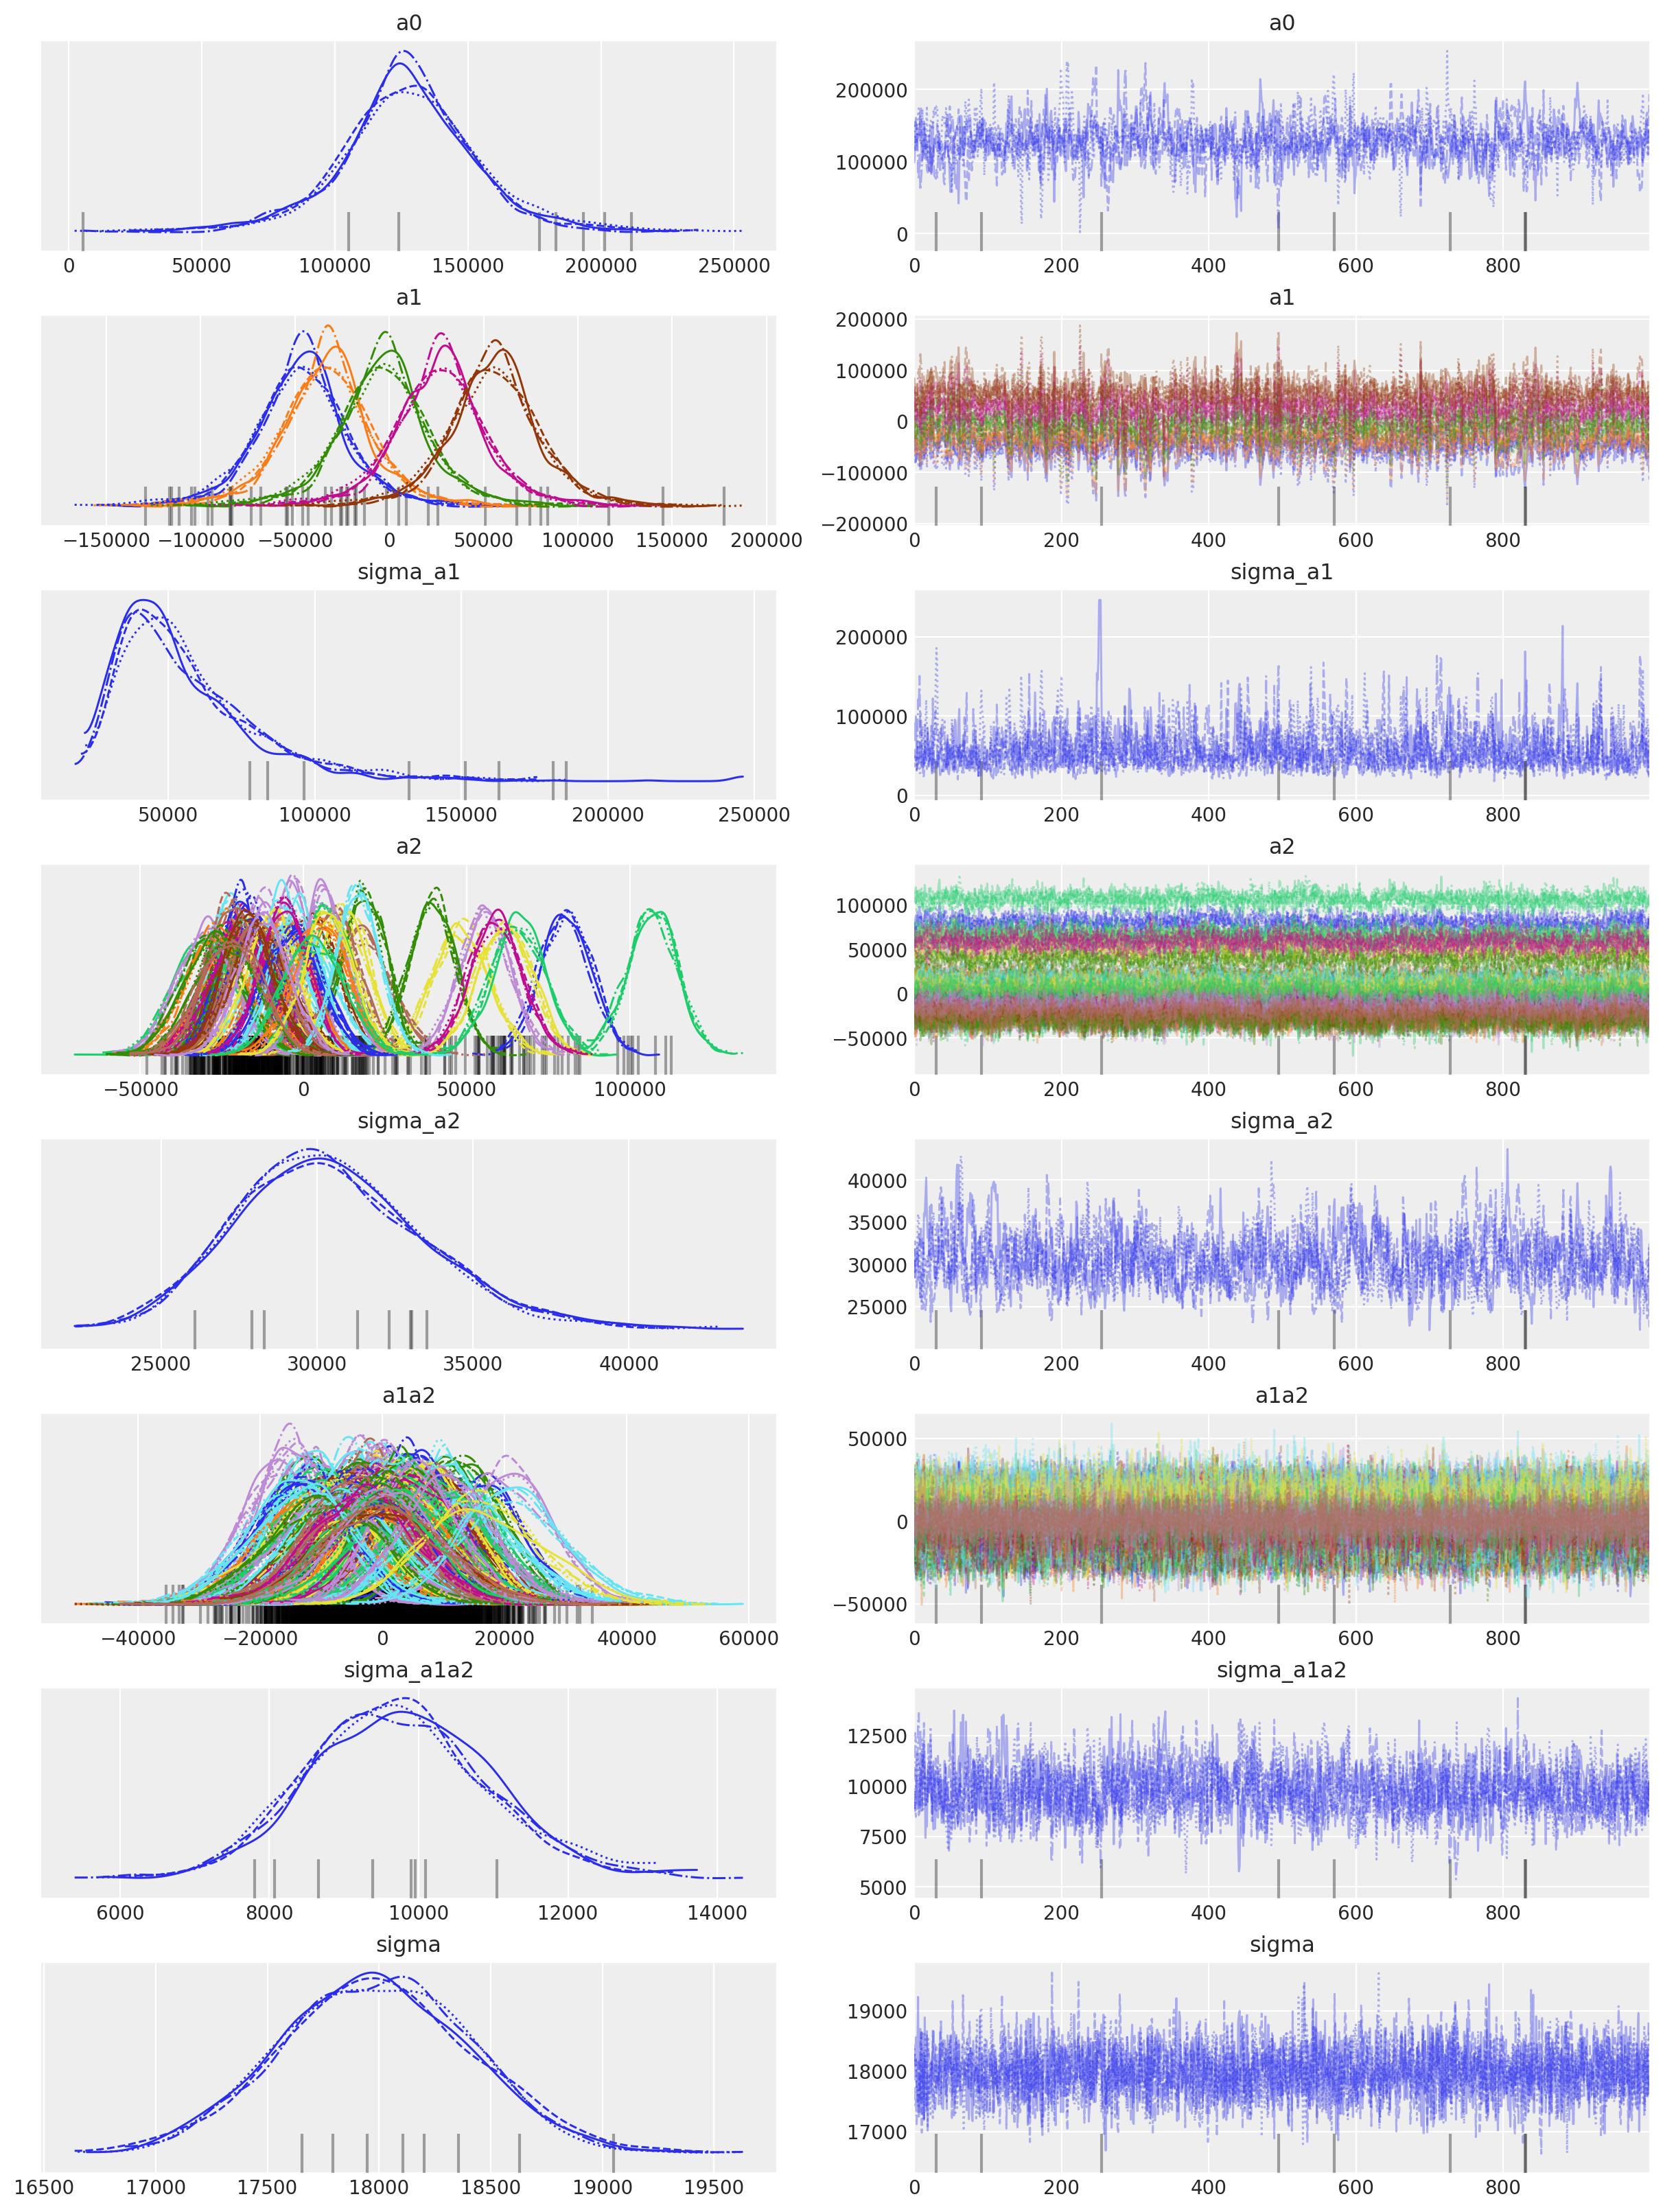

In [18]:
pm.plot_trace(idata, var_names=['a0', 'a1', 'sigma_a1', 'a2', 'sigma_a2', 'a1a2', 'sigma_a1a2', 'sigma']);

In [19]:
post = az.extract(idata.posterior)
len(post['sample'])
post

<xarray.Dataset>
Dimensions:     (sample: 4000, rank: 5, dept: 60, a1_dim_0: 5, a2_dim_0: 60,
                 a1a2_dim_0: 5, a1a2_dim_1: 60)
Coordinates:
  * rank        (rank) <U7 'Assis' 'Assoc' 'Full' 'Endow' 'Disting'
  * dept        (dept) <U4 'ACTG' 'AFRO' 'AMST' 'ANTH' ... 'STAT' 'TELC' 'THTR'
  * a1_dim_0    (a1_dim_0) int64 0 1 2 3 4
  * a2_dim_0    (a2_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 52 53 54 55 56 57 58 59
  * a1a2_dim_0  (a1a2_dim_0) int64 0 1 2 3 4
  * a1a2_dim_1  (a1a2_dim_1) int64 0 1 2 3 4 5 6 7 8 ... 52 53 54 55 56 57 58 59
  * sample      (sample) object MultiIndex
  * chain       (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw        (sample) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    a0_tilde    (sample) float64 -0.05094 0.1101 0.2266 ... 0.1155 0.1499
    a1_tilde    (rank, sample) float64 -0.1566 -0.7501 -0.7978 ... 1.791 1.44
    a2_tilde    (dept, sample) float64 2.487 2.839 2.912 ... -0.7702 -0.4199
    a1a2_tilde  (rank, dept, sample) float64 0.6764 1.367 ... -0.241 0.02851
    sigma_a1    (sample) float64 9.055e+04 6.965e+04 ... 2.387e+04 2.749e+04
    sigma_a2    (sample) float64 3.179e+04 2.91e+04 ... 2.891e+04 2.826e+04
    sigma_a1a2  (sample) float64 8.86e+03 9.375e+03 ... 1.017e+04 9.194e+03
    sigma       (sample) float64 1.843e+04 1.787e+04 ... 1.883e+04 1.838e+04
    a0          (sample) float64 9.917e+04 1.348e+05 ... 1.36e+05 1.436e+05
    a1          (a1_dim_0, sample) float64 -1.418e+04 -5.225e+04 ... 3.958e+04
    a2          (a2_dim_0, sample) float64 7.906e+04 8.261e+04 ... -1.187e+04
    a1a2        (a1a2_dim_0, a1a2_dim_1, sample) float64 5.993e+03 ... 262.1
Attributes:
    created_at:                 2022-11-12T19:11:54.681451
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              356.029443025589
    tuning_steps:               1000

In [30]:
post = post.assign(m=(["rank", "dept", "sample"], np.zeros((n_levels1, n_levels2, len(post['sample'])))))
post = post.assign(b1b2=(["rank", "dept", "sample"], np.zeros((n_levels1, n_levels2, len(post['sample'])))))
post

<xarray.Dataset>
Dimensions:     (sample: 4000, rank: 5, dept: 60, a1_dim_0: 5, a2_dim_0: 60,
                 a1a2_dim_0: 5, a1a2_dim_1: 60)
Coordinates:
  * rank        (rank) <U7 'Assis' 'Assoc' 'Full' 'Endow' 'Disting'
  * dept        (dept) <U4 'ACTG' 'AFRO' 'AMST' 'ANTH' ... 'STAT' 'TELC' 'THTR'
  * a1_dim_0    (a1_dim_0) int64 0 1 2 3 4
  * a2_dim_0    (a2_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 52 53 54 55 56 57 58 59
  * a1a2_dim_0  (a1a2_dim_0) int64 0 1 2 3 4
  * a1a2_dim_1  (a1a2_dim_1) int64 0 1 2 3 4 5 6 7 8 ... 52 53 54 55 56 57 58 59
  * sample      (sample) object MultiIndex
  * chain       (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw        (sample) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables: (12/14)
    a0_tilde    (sample) float64 -0.05094 0.1101 0.2266 ... 0.1155 0.1499
    a1_tilde    (rank, sample) float64 -0.1566 -0.7501 -0.7978 ... 1.791 1.44
    a2_tilde    (dept, sample) float64 2.487 2.839 2.912 ... -0.7702 -0.4199
    a1a2_tilde  (rank, dept, sample) float64 0.6764 1.367 ... -0.241 0.02851
    sigma_a1    (sample) float64 9.055e+04 6.965e+04 ... 2.387e+04 2.749e+04
    sigma_a2    (sample) float64 3.179e+04 2.91e+04 ... 2.891e+04 2.826e+04
    ...          ...
    a0          (sample) float64 9.917e+04 1.348e+05 ... 1.36e+05 1.436e+05
    a1          (a1_dim_0, sample) float64 -1.418e+04 -5.225e+04 ... 3.958e+04
    a2          (a2_dim_0, sample) float64 7.906e+04 8.261e+04 ... -1.187e+04
    a1a2        (a1a2_dim_0, a1a2_dim_1, sample) float64 5.993e+03 ... 262.1
    m           (rank, dept, sample) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    b1b2        (rank, dept, sample) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    created_at:                 2022-11-12T19:11:54.681451
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              356.029443025589
    tuning_steps:               1000

In [31]:
# Transforming the trace data to sum-to-zero values
for (j1, j2) in np.ndindex(n_levels1, n_levels2):
        post.m[j1, j2] =  (post['a0'] +
                     post['a1'][j1, :] +
                     post['a2'][j2, :] +
                     post['a1a2'][j1, j2, :])

m = post.m
b1b2 = post.b1b2
b0 = m.mean(dim=["rank", "dept"])
b1 = m.mean(dim="dept") - b0
b2 = m.mean(dim="rank") - b0
        
for (j1, j2) in np.ndindex(n_levels1, n_levels2):
        b1b2[j1,j2] = (m[j1, j2] - (b0 + b1[j1] + b2[j2]))

# Below are the values corresponding to the first column of table 20.2
print(f'b0: {format(np.round(np.mean(b0)))}')
# print('b1: {}'.format(np.round(np.mean(b1, axis=1))))
# print('b2: {}'.format(np.round(np.mean(b2, axis=1))[[20,48,12,7]]))
# print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[0,48]))
# print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[2,48]))
# print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[0,12]))
# print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[2,12]))
# print('ySigma: {}'.format(np.round(np.mean(trace1['ySigma']))))

b0: <xarray.DataArray 'm' ()>
array(127091.)


In [33]:
b1b2

<xarray.DataArray 'b1b2' (rank: 5, dept: 60, sample: 4000)>
array([[[ 1.01964286e+04,  1.19109485e+04,  9.36972009e+03, ...,
          9.31107615e+03,  9.15915544e+03,  1.26680046e+04],
        [-1.30576738e+04,  2.17073893e+03,  6.52353885e+03, ...,
          6.87570761e+03, -6.77055107e+03, -8.09990199e+03],
        [-7.37192195e+03,  3.32563880e+03,  8.83218959e+03, ...,
         -6.11705613e+02, -9.96079696e+03,  1.05941754e+04],
        ...,
        [ 2.34649190e+04, -1.48837255e+04,  2.59947513e+03, ...,
         -3.38649413e+03,  3.12467220e+02, -8.27649735e+03],
        [ 3.34083215e+02, -3.83191961e+03,  1.17224540e+03, ...,
          6.73906400e+03,  4.61164390e+03, -8.07629372e+03],
        [-5.27922277e+03, -8.43308168e+02, -1.37557748e+03, ...,
          2.33360806e+01, -3.91904839e+03, -6.27277773e+02]],

       [[ 1.92815470e+04,  1.03391030e+04,  1.30393485e+04, ...,
          2.09052069e+03,  1.15273579e+04,  7.15359391e+03],
        [-2.19902840e+02,  6.91995532e+02, -1.21608638e+04, ...,
         -6.82565359e+03, -4.51455631e+03, -1.26681809e+04],
        [-1.31529111e+03, -9.65762086e+03, -5.21136683e+03, ...,
         -2.03037958e+04, -7.00585123e+03, -4.94470964e+03],
...
        [-8.73828849e+03,  1.02498091e+04,  8.07441377e+02, ...,
          5.73069812e+03, -3.09741621e+03, -1.18511636e+03],
        [-6.33323084e+03,  1.04072893e+04, -7.18931148e+02, ...,
         -5.57494500e+03, -1.31775161e+04,  5.04828255e+02],
        [ 1.00389919e+04, -2.16122700e+02,  7.94226637e+03, ...,
          1.30477636e+03, -6.25426984e+03,  5.15044355e+02]],

       [[-5.28240733e+03,  6.94157405e+02,  5.89796694e+03, ...,
          4.83489398e+03,  3.32349175e+03,  5.93338403e+01],
        [-1.27122424e+04,  1.04713214e+04,  4.64506402e+01, ...,
          6.08430623e+03,  9.32584475e+03, -5.58463261e+03],
        [ 1.25091858e+04,  3.00339235e+03, -3.22560835e+03, ...,
         -8.82537980e+02,  5.45886336e+03,  5.04650862e+02],
        ...,
        [-9.39816774e+03, -4.75988051e+03, -5.27161237e+02, ...,
          2.66263563e+03, -4.05284623e+03, -9.57283372e+03],
        [ 8.26691207e+02, -2.25736404e+03, -1.33210734e+03, ...,
          4.24683589e+03, -5.03742732e+03,  1.02842186e+04],
        [-9.42322893e+03,  9.10157699e+03,  1.18435638e+03, ...,
          9.89610757e+03,  6.65364082e+02,  5.07975224e+03]]])
Coordinates:
  * rank     (rank) <U7 'Assis' 'Assoc' 'Full' 'Endow' 'Disting'
  * dept     (dept) <U4 'ACTG' 'AFRO' 'AMST' 'ANTH' ... 'STAT' 'TELC' 'THTR'
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

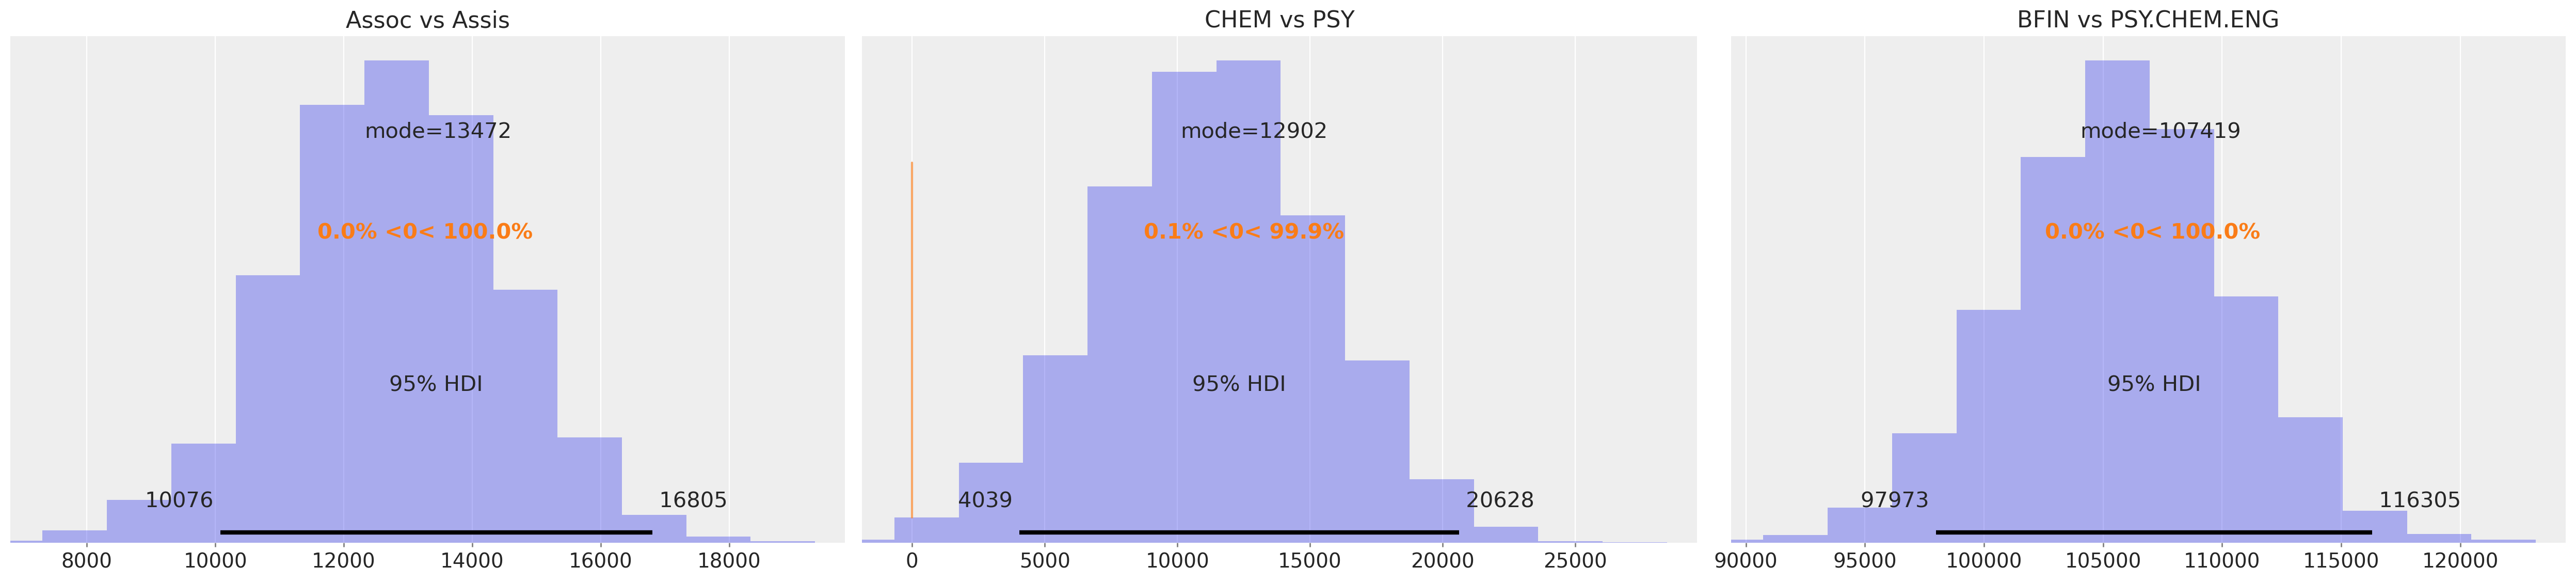

In [41]:
# Create a dict of contrasts using label-based indexing
contrasts = {"Assoc vs Assis": b1.sel(rank="Assoc") - b1.sel(rank="Assis"),
            "CHEM vs PSY": b2.sel(dept="CHEM") - b2.sel(dept="PSY"),
            "BFIN vs PSY.CHEM.ENG": b2.sel(dept="BFIN") - b2.sel(dept=["PSY", "CHEM", "ENG"]).mean()}
az.plot_posterior(contrasts, kind="hist", point_estimate="mode", ref_val=0);


In [37]:
# The posteriors for the main contrasts can be calculated directly from the parameters.
# The posterior for the interaction contrast (rightmost plot) however, is calculated as follows.

# Full vs Assis
P = np.zeros(n_levels1, dtype=int)
P[df.Pos.cat.categories == 'Full'] = 1
P[df.Pos.cat.categories == 'Assis'] = -1

# CHEM vs PSY
O = np.zeros(n_levels2, dtype=int)
O[df.Org.cat.categories == 'CHEM'] = 1
O[df.Org.cat.categories == 'PSY'] = -1

# The signs in the above vectors can be flipped, the end result (posterior) will be the same.
# Using the outer product of these two vectors, we get the matrix we need to multiply
# with the trace values of b1b2.
ic_factors = np.outer(P,O)
pd.DataFrame(ic_factors, index=df.Pos.cat.categories, columns=df.Org.cat.categories)

ACTG  AFRO  AMST  ANTH  APHS  AST  BEPP  BFIN  BI  BLAN  ...  RPAD  \
Assis       0     0     0     0     0    0     0     0   0     0  ...     0   
Assoc       0     0     0     0     0    0     0     0   0     0  ...     0   
Full        0     0     0     0     0    0     0     0   0     0  ...     0   
Endow       0     0     0     0     0    0     0     0   0     0  ...     0   
Disting     0     0     0     0     0    0     0     0   0     0  ...     0   

         SLIS  SLS  SOC  SPAN  SPEA  SPHS  STAT  TELC  THTR  
Assis       0    0    0     0     0     0     0     0     0  
Assoc       0    0    0     0     0     0     0     0     0  
Full        0    0    0     0     0     0     0     0     0  
Endow       0    0    0     0     0     0     0     0     0  
Disting     0    0    0     0     0     0     0     0     0  

[5 rows x 60 columns]

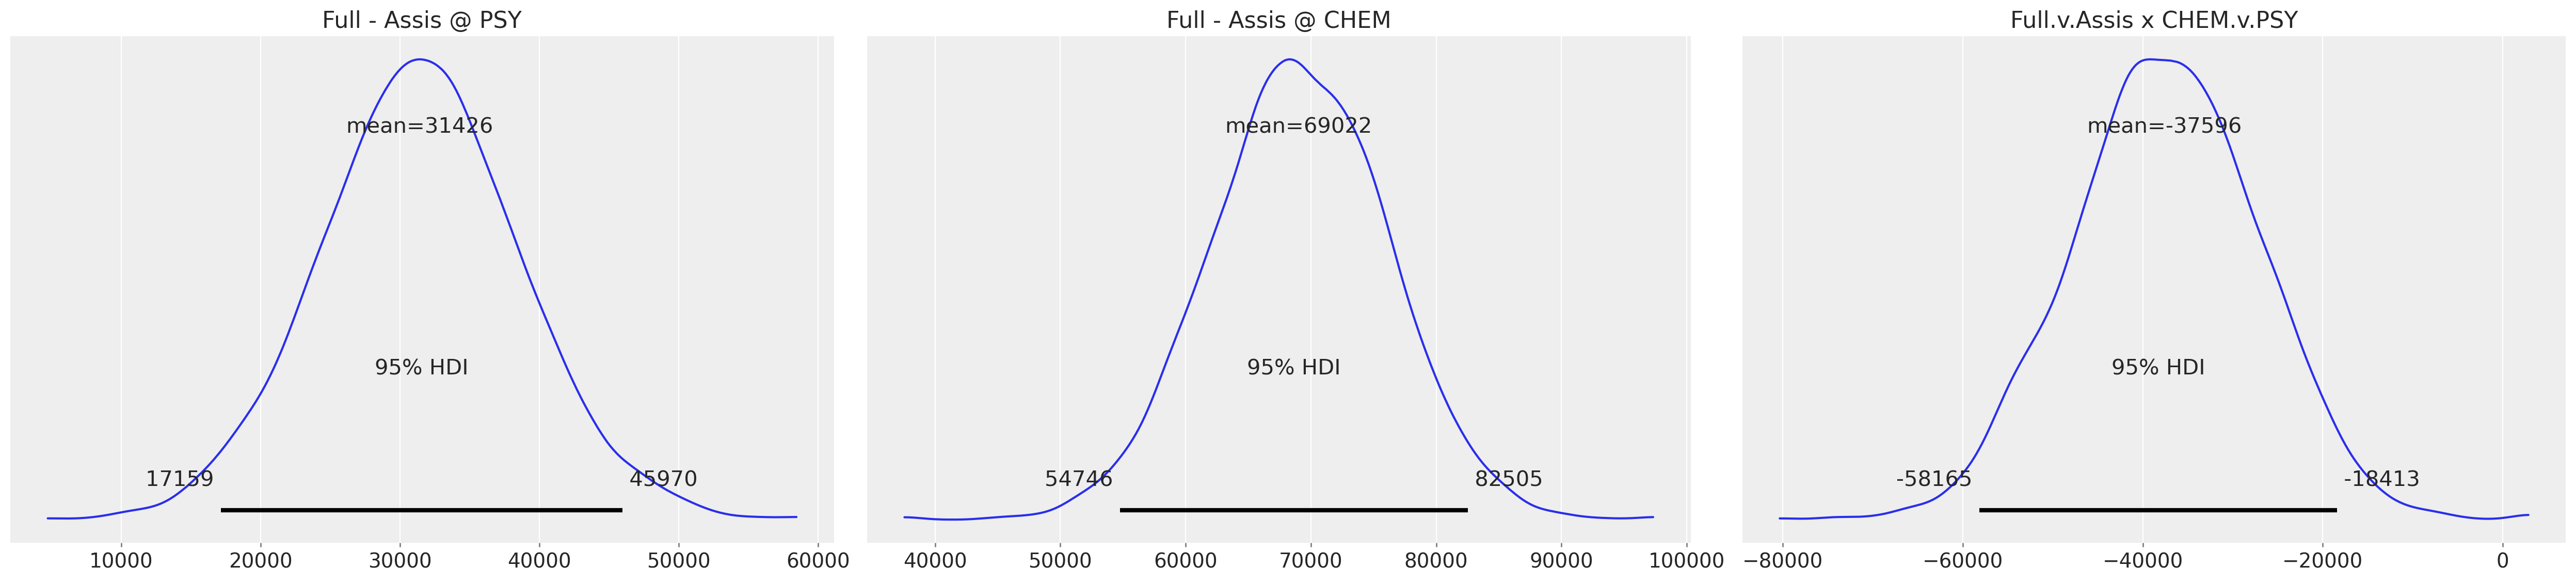

In [43]:
interactions = {"Full - Assis @ PSY": m.sel(rank="Full", dept="PSY") - m.sel(rank="Assis", dept="PSY"),
                "Full - Assis @ CHEM": m.sel(rank="Full", dept="CHEM") - m.sel(rank="Assis", dept="CHEM"),
               "Full.v.Assis x CHEM.v.PSY": 
                (b1b2.sel(rank="Full", dept="PSY") - b1b2.sel(rank="Assis", dept="PSY")) - 
                (b1b2.sel(rank="Full", dept="CHEM") - b1b2.sel(rank="Assis", dept="CHEM"))}
az.plot_posterior(interactions, combine_dims={"sample"});
# interactions

In [45]:
b1b2

<xarray.DataArray 'b1b2' (rank: 5, dept: 60, sample: 4000)>
array([[[ 1.01964286e+04,  1.19109485e+04,  9.36972009e+03, ...,
          9.31107615e+03,  9.15915544e+03,  1.26680046e+04],
        [-1.30576738e+04,  2.17073893e+03,  6.52353885e+03, ...,
          6.87570761e+03, -6.77055107e+03, -8.09990199e+03],
        [-7.37192195e+03,  3.32563880e+03,  8.83218959e+03, ...,
         -6.11705613e+02, -9.96079696e+03,  1.05941754e+04],
        ...,
        [ 2.34649190e+04, -1.48837255e+04,  2.59947513e+03, ...,
         -3.38649413e+03,  3.12467220e+02, -8.27649735e+03],
        [ 3.34083215e+02, -3.83191961e+03,  1.17224540e+03, ...,
          6.73906400e+03,  4.61164390e+03, -8.07629372e+03],
        [-5.27922277e+03, -8.43308168e+02, -1.37557748e+03, ...,
          2.33360806e+01, -3.91904839e+03, -6.27277773e+02]],

       [[ 1.92815470e+04,  1.03391030e+04,  1.30393485e+04, ...,
          2.09052069e+03,  1.15273579e+04,  7.15359391e+03],
        [-2.19902840e+02,  6.91995532e+02, -1.21608638e+04, ...,
         -6.82565359e+03, -4.51455631e+03, -1.26681809e+04],
        [-1.31529111e+03, -9.65762086e+03, -5.21136683e+03, ...,
         -2.03037958e+04, -7.00585123e+03, -4.94470964e+03],
...
        [-8.73828849e+03,  1.02498091e+04,  8.07441377e+02, ...,
          5.73069812e+03, -3.09741621e+03, -1.18511636e+03],
        [-6.33323084e+03,  1.04072893e+04, -7.18931148e+02, ...,
         -5.57494500e+03, -1.31775161e+04,  5.04828255e+02],
        [ 1.00389919e+04, -2.16122700e+02,  7.94226637e+03, ...,
          1.30477636e+03, -6.25426984e+03,  5.15044355e+02]],

       [[-5.28240733e+03,  6.94157405e+02,  5.89796694e+03, ...,
          4.83489398e+03,  3.32349175e+03,  5.93338403e+01],
        [-1.27122424e+04,  1.04713214e+04,  4.64506402e+01, ...,
          6.08430623e+03,  9.32584475e+03, -5.58463261e+03],
        [ 1.25091858e+04,  3.00339235e+03, -3.22560835e+03, ...,
         -8.82537980e+02,  5.45886336e+03,  5.04650862e+02],
        ...,
        [-9.39816774e+03, -4.75988051e+03, -5.27161237e+02, ...,
          2.66263563e+03, -4.05284623e+03, -9.57283372e+03],
        [ 8.26691207e+02, -2.25736404e+03, -1.33210734e+03, ...,
          4.24683589e+03, -5.03742732e+03,  1.02842186e+04],
        [-9.42322893e+03,  9.10157699e+03,  1.18435638e+03, ...,
          9.89610757e+03,  6.65364082e+02,  5.07975224e+03]]])
Coordinates:
  * rank     (rank) <U7 'Assis' 'Assoc' 'Full' 'Endow' 'Disting'
  * dept     (dept) <U4 'ACTG' 'AFRO' 'AMST' 'ANTH' ... 'STAT' 'TELC' 'THTR'
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

In [ ]:
print(post["a1"].values.shape)
print(m.shape)
test = np.mean(m, axis=1)
post["b0"].values.shape
# test.shape
test = np.mean(m, axis=1) - post["b0"].values

In [ ]:
post

In [ ]:
post["b0"].data[0:10]